In [1]:
from mmdet.datasets import CocoDataset
import json
import os
import random
import numpy as np
from copy import deepcopy

def gen_missing_labels(ann_file, seed: int = 0):
    random.seed(seed)

    with open(ann_file, "r") as fp:
        anno = json.load(fp)

    annots = anno["annotations"]

    N = len(annots)
    M = max(int(N * 0.05), 1)
    print(f"N={N}, M={M}")

    random.shuffle(annots)

    no_set = annots[:M]
    ok_set = annots[M:]

    for idx, ann in enumerate(no_set):
        ann["noise"] = 3

    for ann in ok_set:
        ann["noise"] = 0

    anno["annotations"] = no_set + ok_set

    return anno

In [2]:
# dname = "aerial-maritime"
# dname = "pklot"
dname = "d6-dice"
# dname = "bccd"

ann_file = f'/mnt/ssd2/sc_datasets_det/{dname}/annotations/instances_train.json'

anno = gen_missing_labels(ann_file)

N=899, M=44


In [3]:
cnt = 0
for idx, ann in enumerate(anno["annotations"]):
    if ann["noise"] == 3:
        cnt += 1
        print(idx)

print(cnt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [4]:
cnt = 0
for idx, ann in enumerate(anno["annotations"]):
    if ann["noise"] == 2:
        cnt += 1
        print(idx)
        print(ann)
        break

print(cnt)

0


In [5]:
for idx, ann in enumerate(anno["annotations"]):
    if ann["noise"] == 3:
        print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [6]:
anno["annotations"]

[{'id': 223,
  'image_id': 146,
  'category_id': 3,
  'segmentation': [],
  'area': 38218.0,
  'bbox': [1787.0, 1722.0, 194.0, 197.0],
  'iscrowd': 0,
  'noise': 3},
 {'id': 322,
  'image_id': 161,
  'category_id': 6,
  'segmentation': [],
  'area': 40572.0,
  'bbox': [1116.0, 1629.0, 207.0, 196.0],
  'iscrowd': 0,
  'noise': 3},
 {'id': 864,
  'image_id': 246,
  'category_id': 3,
  'segmentation': [],
  'area': 22475.0,
  'bbox': [1084.0, 961.0, 155.0, 145.0],
  'iscrowd': 0,
  'noise': 3},
 {'id': 365,
  'image_id': 168,
  'category_id': 5,
  'segmentation': [],
  'area': 33616.0,
  'bbox': [754.0, 1267.0, 191.0, 176.0],
  'iscrowd': 0,
  'noise': 3},
 {'id': 503,
  'image_id': 190,
  'category_id': 2,
  'segmentation': [],
  'area': 19738.0,
  'bbox': [1387.0, 709.0, 139.0, 142.0],
  'iscrowd': 0,
  'noise': 3},
 {'id': 880,
  'image_id': 248,
  'category_id': 3,
  'segmentation': [],
  'area': 22946.0,
  'bbox': [990.0, 1155.0, 149.0, 154.0],
  'iscrowd': 0,
  'noise': 3},
 {'id': 

In [7]:
dir_path, fname = os.path.split(ann_file)
name, ext = os.path.splitext(fname) 

new_fpath = os.path.join(dir_path, name + "_noise" + ext)

with open(new_fpath, "w") as fp:
    json.dump(anno, fp)
    print(new_fpath)

/mnt/ssd2/sc_datasets_det/d6-dice/annotations/instances_train_noise.json


In [8]:
img_size = (992, 736)
img_norm_cfg = dict(mean=[0, 0, 0], std=[255, 255, 255], to_rgb=True)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='MinIoURandomCrop',
        min_ious=(0.1, 0.3, 0.5, 0.7, 0.9),
        min_crop_size=0.3),
    dict(
        type='Resize',
        img_scale=[(992, 736), (896, 736), (1088, 736), (992, 672), (992, 800)],
        multiscale_mode='value',
        keep_ratio=False),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='DefaultFormatBundle'),
    dict(type="LabelNoiseBundle"),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'noise_labels', 'anno_ids'])
]

In [20]:
from mmdet.datasets.builder import PIPELINES
from mmdet.datasets.coco import LabelNoiseCocoDataset
from mmcv.parallel import DataContainer as DC
from mmdet.datasets.pipelines import to_tensor
from mmdet.datasets import CocoDataset
import json
import numpy as np

img_size = (992, 736)
img_norm_cfg = dict(mean=[0, 0, 0], std=[255, 255, 255], to_rgb=True)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    # dict(
    #     type='MinIoURandomCrop',
    #     min_ious=(0.1, 0.3, 0.5, 0.7, 0.9),
    #     min_crop_size=0.3),
    # dict(
    #     type='Resize',
    #     img_scale=[(992, 736), (896, 736), (1088, 736), (992, 672), (992, 800)],
    #     multiscale_mode='value',
    #     keep_ratio=False),
    dict(type='Resize', img_scale=img_size),
    dict(type='RandomFlip', flip_ratio=0.0),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='DefaultFormatBundle'),
    dict(type="LabelNoiseBundle"),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'noise_labels', 'anno_ids', 'gt_bboxes_ignore'])
]

ann_file = f'/mnt/ssd2/sc_datasets_det/{dname}/annotations/instances_train_noise.json'
img_prefix = f'/mnt/ssd2/sc_datasets_det/{dname}/images/train'

with open(ann_file, "r") as fp:
    anno = json.load(fp)

classes = [ele["name"] for ele in anno["categories"]]

dataset = LabelNoiseCocoDataset(
    ann_file=ann_file,
    pipeline=train_pipeline,
    classes=classes,
    data_root="",
    img_prefix=img_prefix,
    seg_prefix=None,
    proposal_file=None,
    test_mode=False,
    filter_empty_gt=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [10]:
classes

['dice1', 'dice2', 'dice3', 'dice4', 'dice5', 'dice6']

In [ ]:
import mmcv
import matplotlib.pyplot as plt
from mmdet.core.visualization import imshow_det_bboxes

cnt = 0
for idx, item in enumerate(dataset):
    if len(item["gt_bboxes_ignore"].data) == 0:
        continue
    img = item["img"].data.numpy()
    img = np.transpose(img, (1, 2, 0))

    imshow_det_bboxes(
        img=img,
        bboxes=item["gt_bboxes"].data.numpy(),
        labels=item["gt_labels"].data.numpy(),
        class_names=classes
    )
    cnt += 1

    if cnt > 5:
        break

In [44]:
from noisy_label.gen_config import get_cfg
from noisy_label.extract_feat import load_best_ckpt
from mmdet.models import build_detector

cfg = get_cfg(dname)

work_dir = "noise_output/16/d6-dice"
cfg.work_dir = work_dir

model = build_detector(
    cfg.model, train_cfg=cfg.get("train_cfg"), test_cfg=cfg.get("test_cfg")
)

model = load_best_ckpt(model, output_dir=work_dir)
model.eval()
model.cfg = cfg

2022-11-22 11:16:31,255 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Use small val ann file
ann_files["train"] /mnt/ssd2/sc_datasets_det/d6-dice/annotations/instances_train.json
N=899 cnt_bbox_noise=0 cnt_cls_noise=0
Load best epoch=40


/home/vinnamki/training_extensions/external/mmdetection/submodule/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


In [49]:
from mmdet.apis.inference import inference_detector

outputs = inference_detector(model, [img * 255])

In [ ]:
from pycocotools.mask import iou
from mmdet.ops.nms import nms

cnt = 0
iou_thresholds = 0.8

for idx, item in enumerate(dataset):
    img = item["img"].data.numpy()
    img = np.transpose(img, (1, 2, 0))

    if len(item["gt_bboxes_ignore"].data) == 0:
        continue

    imshow_det_bboxes(
        img=img,
        bboxes=item["gt_bboxes"].data.numpy(),
        labels=item["gt_labels"].data.numpy(),
        class_names=classes
    )
    cnt += 1

    outputs = inference_detector(model, [img * 255])
    dt = np.concatenate(outputs[0], axis=0)
    conf = dt[:, 4]
    dt = dt[:, :4]
    labels = [np.asarray([cid] * len(arr)) for cid, arr in enumerate(outputs[0])]
    labels = np.concatenate(labels, axis=0)

    dt, indices = nms(dt, conf, iou_thresholds)
    labels = labels[indices]

    imshow_det_bboxes(
        img=img,
        bboxes=dt,
        labels=labels,
        class_names=classes
    )

    gt = item["gt_bboxes"].data.numpy()
    ious = iou(gt, dt[:, :4], np.zeros([len(gt)]))
    ious = ious.max(axis=0)

    dt = dt[ious < iou_thresholds]
    labels = labels[ious < iou_thresholds]

    imshow_det_bboxes(
        img=img,
        bboxes=dt,
        labels=labels,
        class_names=classes
    )
    if cnt > 3:
        break

In [1]:
from noisy_label.gen_config import (
    gen_missing_labels,
    gen_noise_labels,
    get_cfg,
    get_miss_noise_size,
    save_anno,
    gen_subset_anno,
    read_train_anno,
    merge_anno,
    get_init_subset_ids,
    get_bbox_noise_size,
    get_cls_noise_size,
    get_size,
)
from noisy_label.run_al_scenario import pred_train_dataloader, train_al_scenario
from noisy_label.run_al_scenario import test_al_scenario
from tempfile import TemporaryDirectory
from noisy_label.extract_feat import get_feats, get_cand
from noisy_label.filtration import (
    correct,
    correct_missing_labels,
    drop,
    nothing,
    get_noisy_cands,
)
import pandas as pd
import os
import argparse

dname = "d6-dice"
root_dir = "/mnt/ssd2/sc_datasets_det/"
n_add = 16
seed = 0
noise_rate = 0.05
cycle = 1
work_dir = "/tmp/work"

full_anno = read_train_anno(dname, root_dir=root_dir)
subset_ids = get_init_subset_ids(full_anno, n_add, seed=seed)
anno = gen_subset_anno(dname, subset_ids, root_dir=root_dir)
anno = gen_missing_labels(anno, seed=seed, noise_rate=noise_rate)

print(f"Cycle={cycle}, work_dir={work_dir}")
train_ann_file = save_anno(anno, work_dir)
train_cfg = get_cfg(
    dname, root_dir=root_dir, train_ann_file=train_ann_file
)

n_imgs, n_anns = get_size(anno)
n_bbox_noise = get_bbox_noise_size(anno)
n_cls_noise = get_cls_noise_size(anno)
n_miss_noise = get_miss_noise_size(anno)

train_al_scenario(train_cfg, work_dir)
output = test_al_scenario(train_cfg, work_dir)
del output["bbox_mAP_copypaste"]
train_preds = pred_train_dataloader(train_cfg, work_dir)

2022-11-23 12:27:13,239 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Avg annotations per image = 6.4 std = 3.8
Avg annotations per image = 6.4 std = 3.8
N=135, M=6
Cycle=1, work_dir=/tmp/work
Use small val ann file
ann_files["train"] /tmp/work/tmp.json
N=135 cnt_bbox_noise=0 cnt_cls_noise=0 cnt_miss_noise=6
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/vinnamki/training_extensions/external/mmdetection/submodule/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_http loader


2022-11-23 12:27:15,786 - mmdet - INFO - Start running, host: vinnamki@jisunkwo-desktop, work_dir: /tmp/work
2022-11-23 12:27:15,787 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(NORMAL      ) SaveLossDynamicsHook               
(75          ) EarlyStoppingHook                  
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 -------------------- 
after_train_iter:
(A

The model and loaded state dict do not match exactly

size mismatch for bbox_head.atss_cls.weight: copying a param with shape torch.Size([80, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([6, 64, 3, 3]).
size mismatch for bbox_head.atss_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([6]).
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/vinnamki/training_extensions/external/mmdetection/venv/lib/python3.8/site-packages/nncf/torch/__init__.py:23: UserWarning: NNCF provides best results with torch==1.9.1, while current torch version is 1.8.1+cu111 - consider switching to torch==1.9.1
  warnings.warn("NNCF provides best results with torch=={bkc}, "
/home/vinnamki/training_extensions/external/mmdetection/venv/lib/python3.8/site-packages/nncf/torch/dynamic_graph/patch_pytorch.py:163: UserWarning: Not patching unique_dim since it is missing in this version of PyTorch
  warnings.warn("Not patching {} since it is missing in this version of PyTorch".format(op_name))
/home/vinnamki/training_extensions/external/mmdetection/submodule/mmdet/core/anchor/anchor_generator.py:329: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/vinnamki/training_extensions/external/mmdetection/submodule/mmdet/core/anchor/anchor_generator.py:365

[>>>>>>                           ] 7/36, 15.6 task/s, elapsed: 0s, ETA:     2s

/home/vinnamki/training_extensions/external/mmdetection/venv/lib/python3.8/site-packages/nncf/torch/dynamic_graph/wrappers.py:53: UserWarning: You are using DataParallel, which may cause significant performance issues with dynamic graph building. Consider using distributed training (DistributedDataParallel) instead
  warnings.warn("You are using DataParallel, which may cause significant performance issues with dynamic graph "


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 29.9 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:27:37,622 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 376  | 0.983  | 0.273 |
| dice2 | 61  | 379  | 0.967  | 0.415 |
| dice3 | 61  | 364  | 0.951  | 0.268 |
| dice4 | 58  | 428  | 0.966  | 0.225 |
| dice5 | 62  | 420  | 1.000  | 0.415 |
| dice6 | 57  | 384  | 1.000  | 0.381 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.329 |
+-------+-----+------+--------+-------+
2022-11-23 12:27:37,755 - mmdet - INFO - Now best checkpoint is saved as best_mAP_epoch_1.pth.
2022-11-23 12:27:37,756 - mmdet - INFO - Best mAP is 0.3295 at 1 epoch.
2022-11-23 12:27:37,756 - mmdet - INFO - Epoch(val) [1][36]	AP50: 0.3290, mAP: 0.3295
2022-11-23 12:27:40,873 - mmdet - INFO - Epoch [2][1/58]	lr: 4.213e-03, eta: 0:03:48, time: 3.034, data_time: 2.851, memory: 8230, loss_cls: 0.3186, loss_bbox: 0.2762, loss_centerness: 0.5971, loss: 1.1920
2022-11-23 12:27:41

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 29.2 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:27:57,041 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 341  | 0.983  | 0.424 |
| dice2 | 61  | 325  | 1.000  | 0.436 |
| dice3 | 61  | 386  | 1.000  | 0.386 |
| dice4 | 58  | 341  | 0.983  | 0.391 |
| dice5 | 62  | 267  | 1.000  | 0.529 |
| dice6 | 57  | 206  | 0.965  | 0.432 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.433 |
+-------+-----+------+--------+-------+
2022-11-23 12:27:57,172 - mmdet - INFO - Now best checkpoint is saved as best_mAP_epoch_2.pth.
2022-11-23 12:27:57,172 - mmdet - INFO - Best mAP is 0.4331 at 2 epoch.
2022-11-23 12:27:57,173 - mmdet - INFO - Epoch(val) [2][36]	AP50: 0.4330, mAP: 0.4331
2022-11-23 12:28:00,309 - mmdet - INFO - Epoch [3][1/58]	lr: 5.760e-03, eta: 0:03:02, time: 3.053, data_time: 2.867, memory: 8230, loss_cls: 0.1847, loss_bbox: 0.1642, loss_centerness: 0.6191, loss: 0.9680
2022-11-23 12:28:00

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 29.7 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:28:16,541 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 299  | 0.950  | 0.514 |
| dice2 | 61  | 347  | 0.967  | 0.360 |
| dice3 | 61  | 272  | 0.967  | 0.476 |
| dice4 | 58  | 164  | 0.759  | 0.397 |
| dice5 | 62  | 237  | 0.984  | 0.671 |
| dice6 | 57  | 214  | 0.965  | 0.541 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.493 |
+-------+-----+------+--------+-------+
2022-11-23 12:28:16,670 - mmdet - INFO - Now best checkpoint is saved as best_mAP_epoch_3.pth.
2022-11-23 12:28:16,670 - mmdet - INFO - Best mAP is 0.4931 at 3 epoch.
2022-11-23 12:28:16,671 - mmdet - INFO - Epoch(val) [3][36]	AP50: 0.4930, mAP: 0.4931
2022-11-23 12:28:19,855 - mmdet - INFO - Epoch [4][1/58]	lr: 7.307e-03, eta: 0:02:35, time: 3.102, data_time: 2.901, memory: 8230, loss_cls: 0.1483, loss_bbox: 0.1692, loss_centerness: 0.5909, loss: 0.9084
2022-11-23 12:28:20

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 29.2 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:28:36,031 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 219  | 0.967  | 0.608 |
| dice2 | 61  | 205  | 0.820  | 0.351 |
| dice3 | 61  | 223  | 0.836  | 0.406 |
| dice4 | 58  | 286  | 0.879  | 0.500 |
| dice5 | 62  | 225  | 0.952  | 0.536 |
| dice6 | 57  | 184  | 0.947  | 0.583 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.497 |
+-------+-----+------+--------+-------+
2022-11-23 12:28:36,161 - mmdet - INFO - Now best checkpoint is saved as best_mAP_epoch_4.pth.
2022-11-23 12:28:36,161 - mmdet - INFO - Best mAP is 0.4974 at 4 epoch.
2022-11-23 12:28:36,162 - mmdet - INFO - Epoch(val) [4][36]	AP50: 0.4970, mAP: 0.4974
2022-11-23 12:28:36,172 - mmdet - INFO - 
Best Score: -inf, Current Score: 0.49738121032714844, Patience: 5 Count: 0
2022-11-23 12:28:39,325 - mmdet - INFO - Epoch [5][1/58]	lr: 8.000e-03, eta: 0:02:13, time: 3.080, data_time

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 30.9 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:28:55,705 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 173  | 0.933  | 0.642 |
| dice2 | 61  | 213  | 0.984  | 0.401 |
| dice3 | 61  | 317  | 0.869  | 0.419 |
| dice4 | 58  | 101  | 0.586  | 0.413 |
| dice5 | 62  | 261  | 0.984  | 0.600 |
| dice6 | 57  | 47   | 0.368  | 0.256 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.455 |
+-------+-----+------+--------+-------+
2022-11-23 12:28:55,776 - mmdet - INFO - Epoch(val) [5][36]	AP50: 0.4550, mAP: 0.4551
2022-11-23 12:28:55,786 - mmdet - INFO - 
Best Score: 0.49738121032714844, Current Score: 0.45509207248687744, Patience: 5 Count: 0
2022-11-23 12:28:58,878 - mmdet - INFO - Epoch [6][1/58]	lr: 8.000e-03, eta: 0:01:52, time: 3.018, data_time: 2.827, memory: 8230, loss_cls: 0.1114, loss_bbox: 0.1602, loss_centerness: 0.5872, loss: 0.8589
2022-11-23 12:28:59,135 - mmdet - INFO - Epoch [6][2/5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 29.2 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:29:15,157 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 120  | 0.817  | 0.640 |
| dice2 | 61  | 218  | 0.967  | 0.458 |
| dice3 | 61  | 307  | 0.967  | 0.449 |
| dice4 | 58  | 184  | 0.810  | 0.473 |
| dice5 | 62  | 299  | 0.968  | 0.636 |
| dice6 | 57  | 199  | 0.965  | 0.581 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.539 |
+-------+-----+------+--------+-------+
2022-11-23 12:29:15,288 - mmdet - INFO - Now best checkpoint is saved as best_mAP_epoch_6.pth.
2022-11-23 12:29:15,289 - mmdet - INFO - Best mAP is 0.5394 at 6 epoch.
2022-11-23 12:29:15,290 - mmdet - INFO - Epoch(val) [6][36]	AP50: 0.5390, mAP: 0.5394
2022-11-23 12:29:15,299 - mmdet - INFO - 
Best Score: 0.49738121032714844, Current Score: 0.5393854975700378, Patience: 5 Count: 1
2022-11-23 12:29:18,527 - mmdet - INFO - Epoch [7][1/58]	lr: 8.000e-03, eta: 0:01:32, time: 3.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 28.6 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:29:34,837 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 137  | 0.900  | 0.653 |
| dice2 | 61  | 196  | 0.852  | 0.431 |
| dice3 | 61  | 209  | 0.770  | 0.428 |
| dice4 | 58  | 199  | 0.776  | 0.497 |
| dice5 | 62  | 259  | 0.952  | 0.648 |
| dice6 | 57  | 202  | 0.930  | 0.563 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.537 |
+-------+-----+------+--------+-------+
2022-11-23 12:29:34,912 - mmdet - INFO - Epoch(val) [7][36]	AP50: 0.5370, mAP: 0.5368
2022-11-23 12:29:34,923 - mmdet - INFO - 
Best Score: 0.5393854975700378, Current Score: 0.5367801785469055, Patience: 5 Count: 0
2022-11-23 12:29:38,053 - mmdet - INFO - Epoch [8][1/58]	lr: 8.000e-03, eta: 0:01:13, time: 3.057, data_time: 2.870, memory: 8230, loss_cls: 0.0646, loss_bbox: 0.1220, loss_centerness: 0.5963, loss: 0.7829
2022-11-23 12:29:38,317 - mmdet - INFO - Epoch [8][2/58]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 29.9 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:29:54,411 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 244  | 0.933  | 0.647 |
| dice2 | 61  | 158  | 0.754  | 0.319 |
| dice3 | 61  | 113  | 0.541  | 0.333 |
| dice4 | 58  | 177  | 0.793  | 0.488 |
| dice5 | 62  | 157  | 0.903  | 0.515 |
| dice6 | 57  | 159  | 0.912  | 0.547 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.475 |
+-------+-----+------+--------+-------+
2022-11-23 12:29:54,482 - mmdet - INFO - Epoch(val) [8][36]	AP50: 0.4750, mAP: 0.4749
2022-11-23 12:29:54,492 - mmdet - INFO - 
Best Score: 0.5393854975700378, Current Score: 0.47487589716911316, Patience: 5 Count: 1
2022-11-23 12:29:57,640 - mmdet - INFO - Epoch [9][1/58]	lr: 8.000e-03, eta: 0:00:55, time: 3.074, data_time: 2.886, memory: 8230, loss_cls: 0.0798, loss_bbox: 0.1323, loss_centerness: 0.5934, loss: 0.8056
2022-11-23 12:29:57,893 - mmdet - INFO - Epoch [9][2/58

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 30.2 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:30:14,126 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 105  | 0.717  | 0.558 |
| dice2 | 61  | 201  | 0.852  | 0.394 |
| dice3 | 61  | 150  | 0.656  | 0.360 |
| dice4 | 58  | 133  | 0.621  | 0.389 |
| dice5 | 62  | 233  | 0.919  | 0.596 |
| dice6 | 57  | 186  | 0.930  | 0.539 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.473 |
+-------+-----+------+--------+-------+
2022-11-23 12:30:14,197 - mmdet - INFO - Epoch(val) [9][36]	AP50: 0.4730, mAP: 0.4728
2022-11-23 12:30:14,206 - mmdet - INFO - 
Best Score: 0.5393854975700378, Current Score: 0.47276899218559265, Patience: 5 Count: 2
2022-11-23 12:30:17,361 - mmdet - INFO - Epoch [10][1/58]	lr: 8.000e-03, eta: 0:00:36, time: 3.081, data_time: 2.898, memory: 8230, loss_cls: 0.0750, loss_bbox: 0.1141, loss_centerness: 0.5914, loss: 0.7806
2022-11-23 12:30:17,605 - mmdet - INFO - Epoch [10][2/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 30.0 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:30:34,043 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 100  | 0.867  | 0.622 |
| dice2 | 61  | 205  | 0.869  | 0.392 |
| dice3 | 61  | 229  | 0.918  | 0.465 |
| dice4 | 58  | 78   | 0.483  | 0.373 |
| dice5 | 62  | 259  | 0.968  | 0.648 |
| dice6 | 57  | 120  | 0.842  | 0.556 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.509 |
+-------+-----+------+--------+-------+
2022-11-23 12:30:34,116 - mmdet - INFO - Epoch(val) [10][36]	AP50: 0.5090, mAP: 0.5094
2022-11-23 12:30:34,126 - mmdet - INFO - 
Best Score: 0.5393854975700378, Current Score: 0.5094199180603027, Patience: 5 Count: 3
2022-11-23 12:30:37,303 - mmdet - INFO - Epoch [11][1/58]	lr: 8.000e-03, eta: 0:00:18, time: 3.102, data_time: 2.917, memory: 8230, loss_cls: 0.0379, loss_bbox: 0.0880, loss_centerness: 0.6138, loss: 0.7397
2022-11-23 12:30:37,558 - mmdet - INFO - Epoch [11][2/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 36/36, 28.9 task/s, elapsed: 1s, ETA:     0sMetrics ('mAP',) are not supported by CocoDataset.evaluate. Falling back to the parent class implementation.

---------------iou_thr: 0.5---------------


2022-11-23 12:30:53,797 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| dice1 | 60  | 131  | 0.817  | 0.572 |
| dice2 | 61  | 173  | 0.836  | 0.390 |
| dice3 | 61  | 161  | 0.705  | 0.415 |
| dice4 | 58  | 150  | 0.638  | 0.356 |
| dice5 | 62  | 212  | 0.952  | 0.640 |
| dice6 | 57  | 120  | 0.825  | 0.569 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.490 |
+-------+-----+------+--------+-------+
2022-11-23 12:30:53,868 - mmdet - INFO - Epoch(val) [11][36]	AP50: 0.4900, mAP: 0.4903
2022-11-23 12:30:54,886 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Load best epoch=8
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[                                                  ] 0/73, elapsed: 0s, ETA:

/home/vinnamki/training_extensions/external/mmdetection/submodule/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 39.8 task/s, elapsed: 2s, ETA:     0s
Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...


2022-11-23 12:30:57,244 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


DONE (t=0.05s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.455
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.283
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.264
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.581
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.581
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.581
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.581
Load best epoch=8
loadi

In [2]:
for ann in anno["annotations"]:
    if ann["noise"] == 3:
        print(ann["image_id"])

5
13
13
13
13
8


In [3]:
from noisy_label.filtration import get_missing_label_cands

/home/vinnamki/training_extensions/external/mmdetection/submodule/mmdet/core/visualization/image.py:75: UserWarning: "font_scale" will be deprecated in v2.9.0,Please use "font_size"
  warnings.warn('"font_scale" will be deprecated in v2.9.0,'


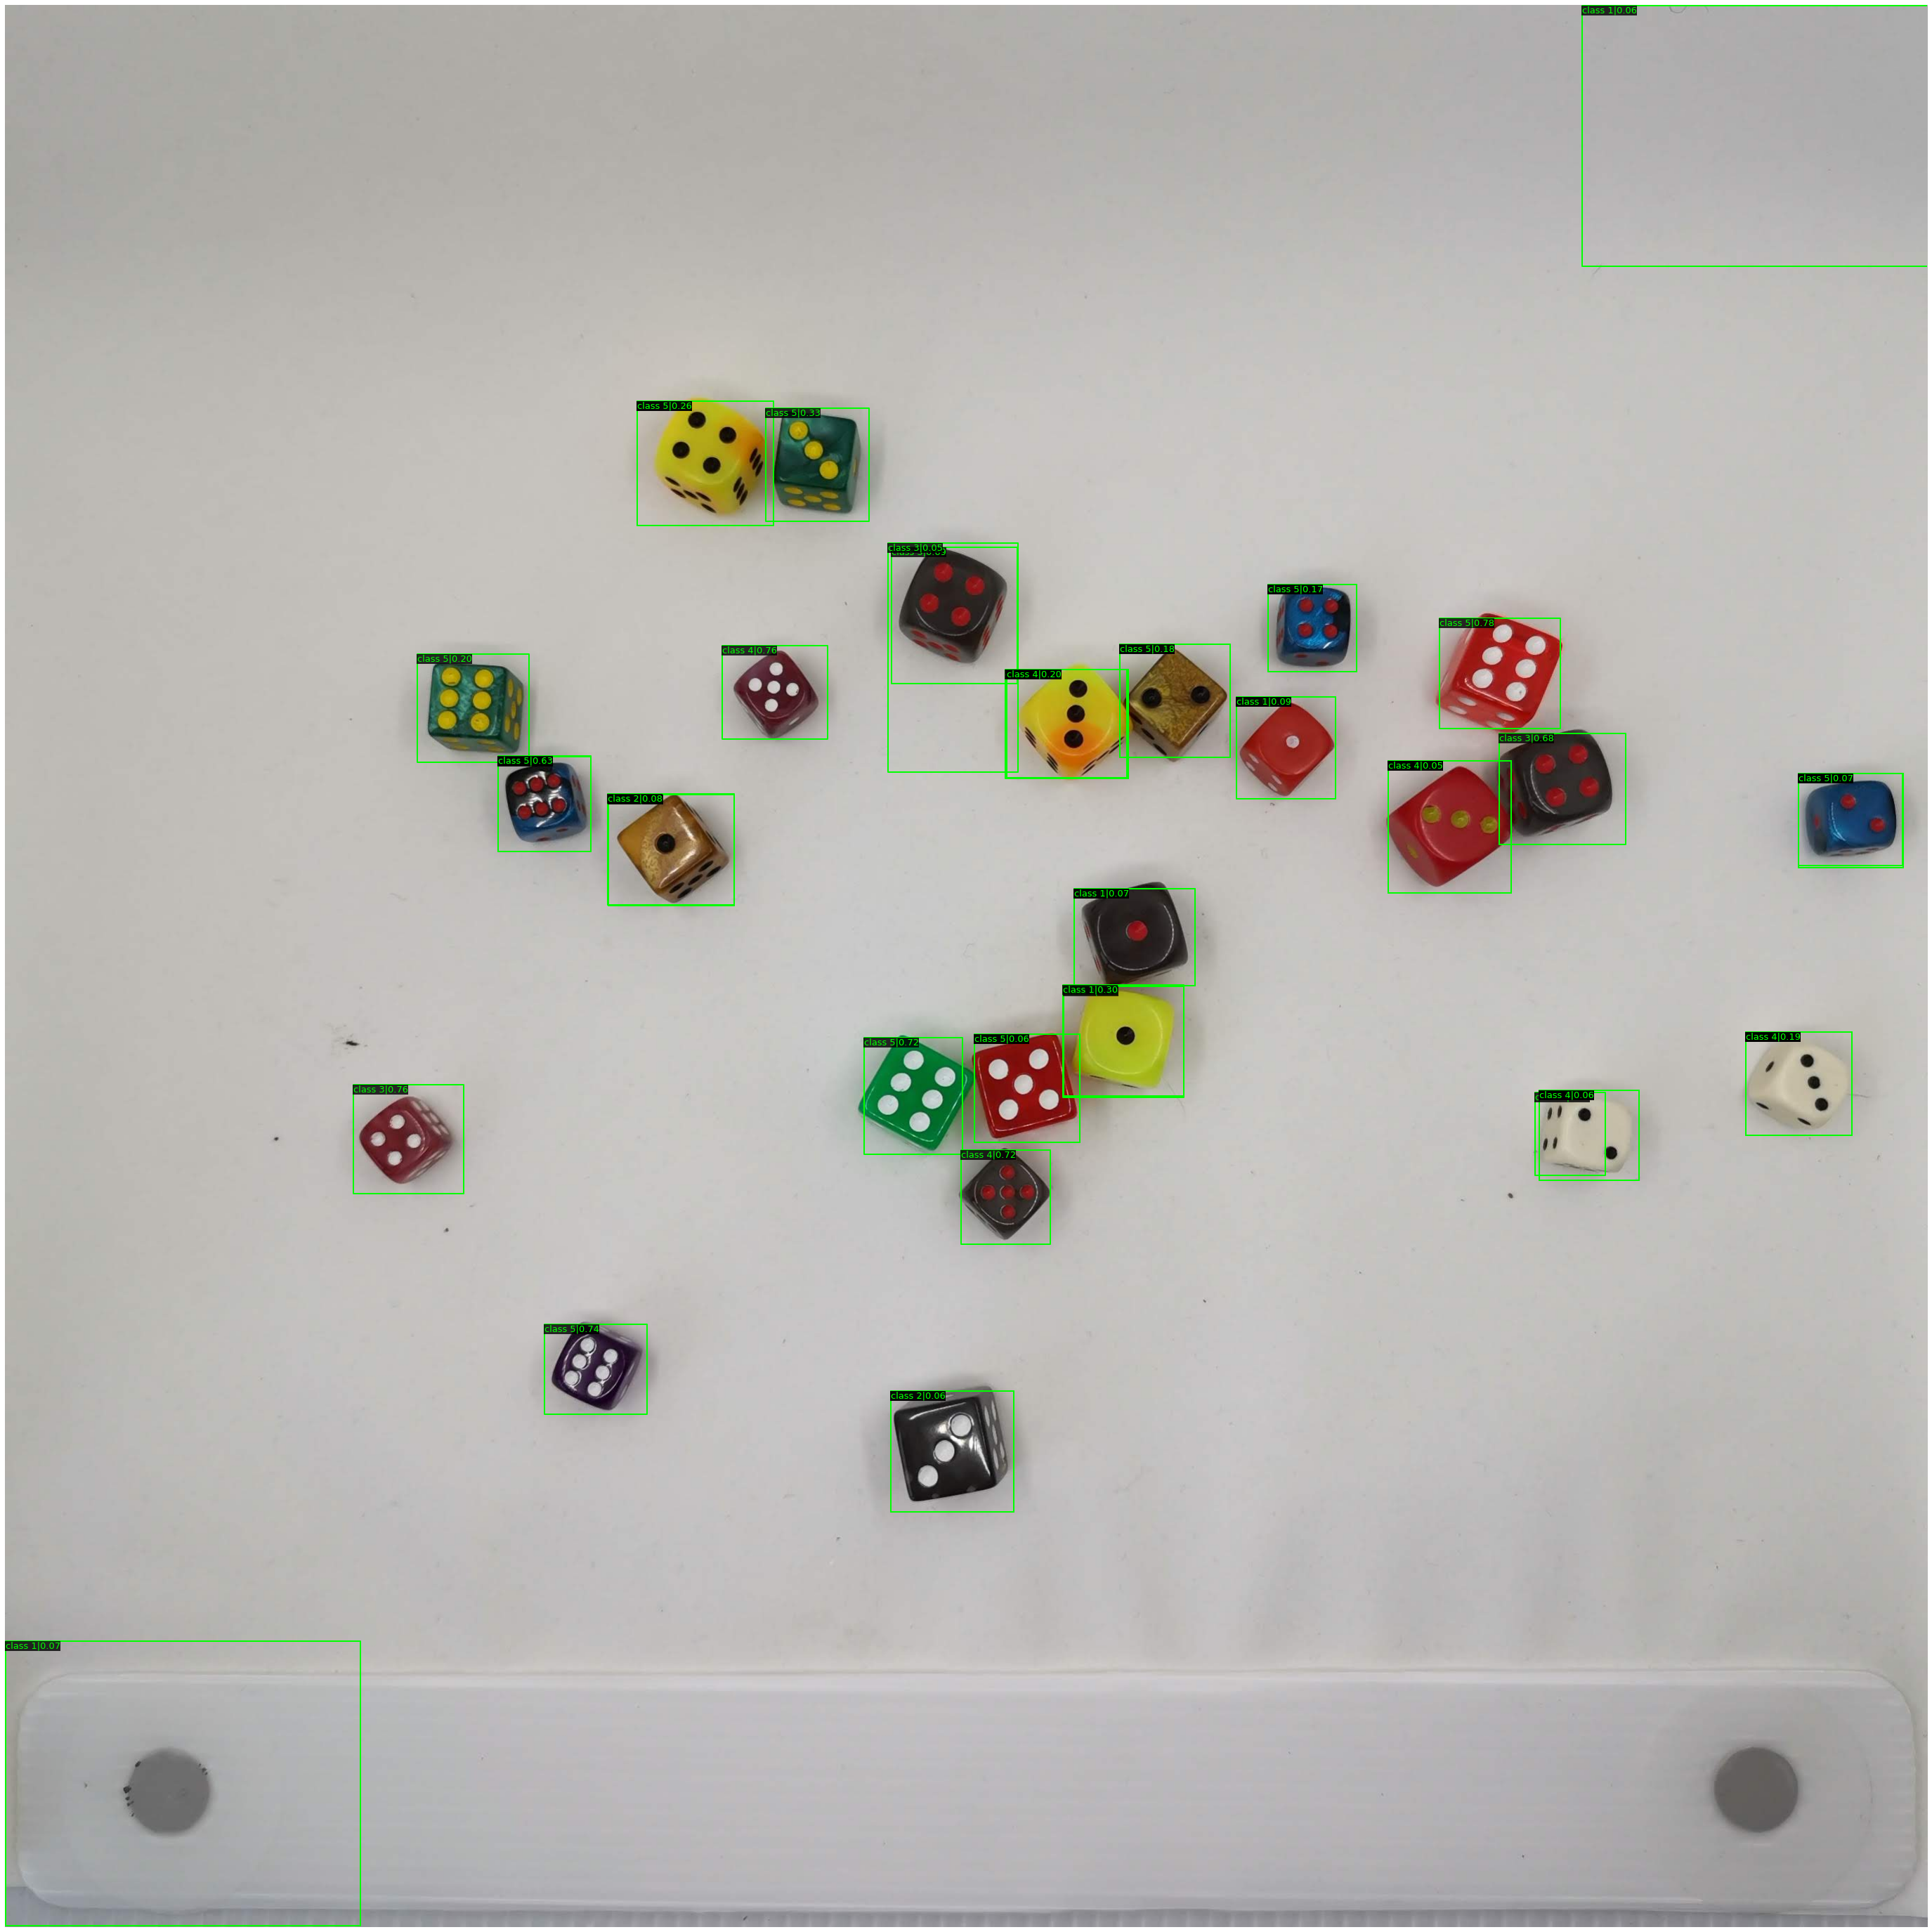

array([[[163, 169, 168],
        [163, 169, 168],
        [163, 169, 168],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[163, 169, 168],
        [163, 169, 168],
        [163, 169, 168],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[163, 169, 168],
        [163, 169, 168],
        [163, 169, 168],
        ...,
        [172, 172, 172],
        [172, 172, 172],
        [172, 172, 172]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [139, 134, 135],
        [138, 133, 134],
        [138, 133, 134]],

       [[ 44, 223,  41],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [139, 134, 135],
        [139, 134, 135],
        [139, 134, 135]],

       [[152, 148, 143],
        [152, 148, 143],
        [151, 147, 142],
        ...,
        [139, 134, 135],
        [139, 134, 135],
        [139, 134, 135]]

In [4]:
import cv2
from mmdet.core.visualization import imshow_det_bboxes
import numpy as np

img_id = 13
preds = train_preds[img_id]
labels = []
for cls_id, p in enumerate(preds):
    labels += [cls_id] * len(p)
labels = np.asarray(labels)
bboxes = np.concatenate(preds, axis=0)

img = anno["images"][img_id]
fpath = os.path.join(train_cfg.data.train.dataset.img_prefix, img["file_name"])
im = cv2.imread(fpath)

imshow_det_bboxes(im, bboxes, labels)

56 29 29


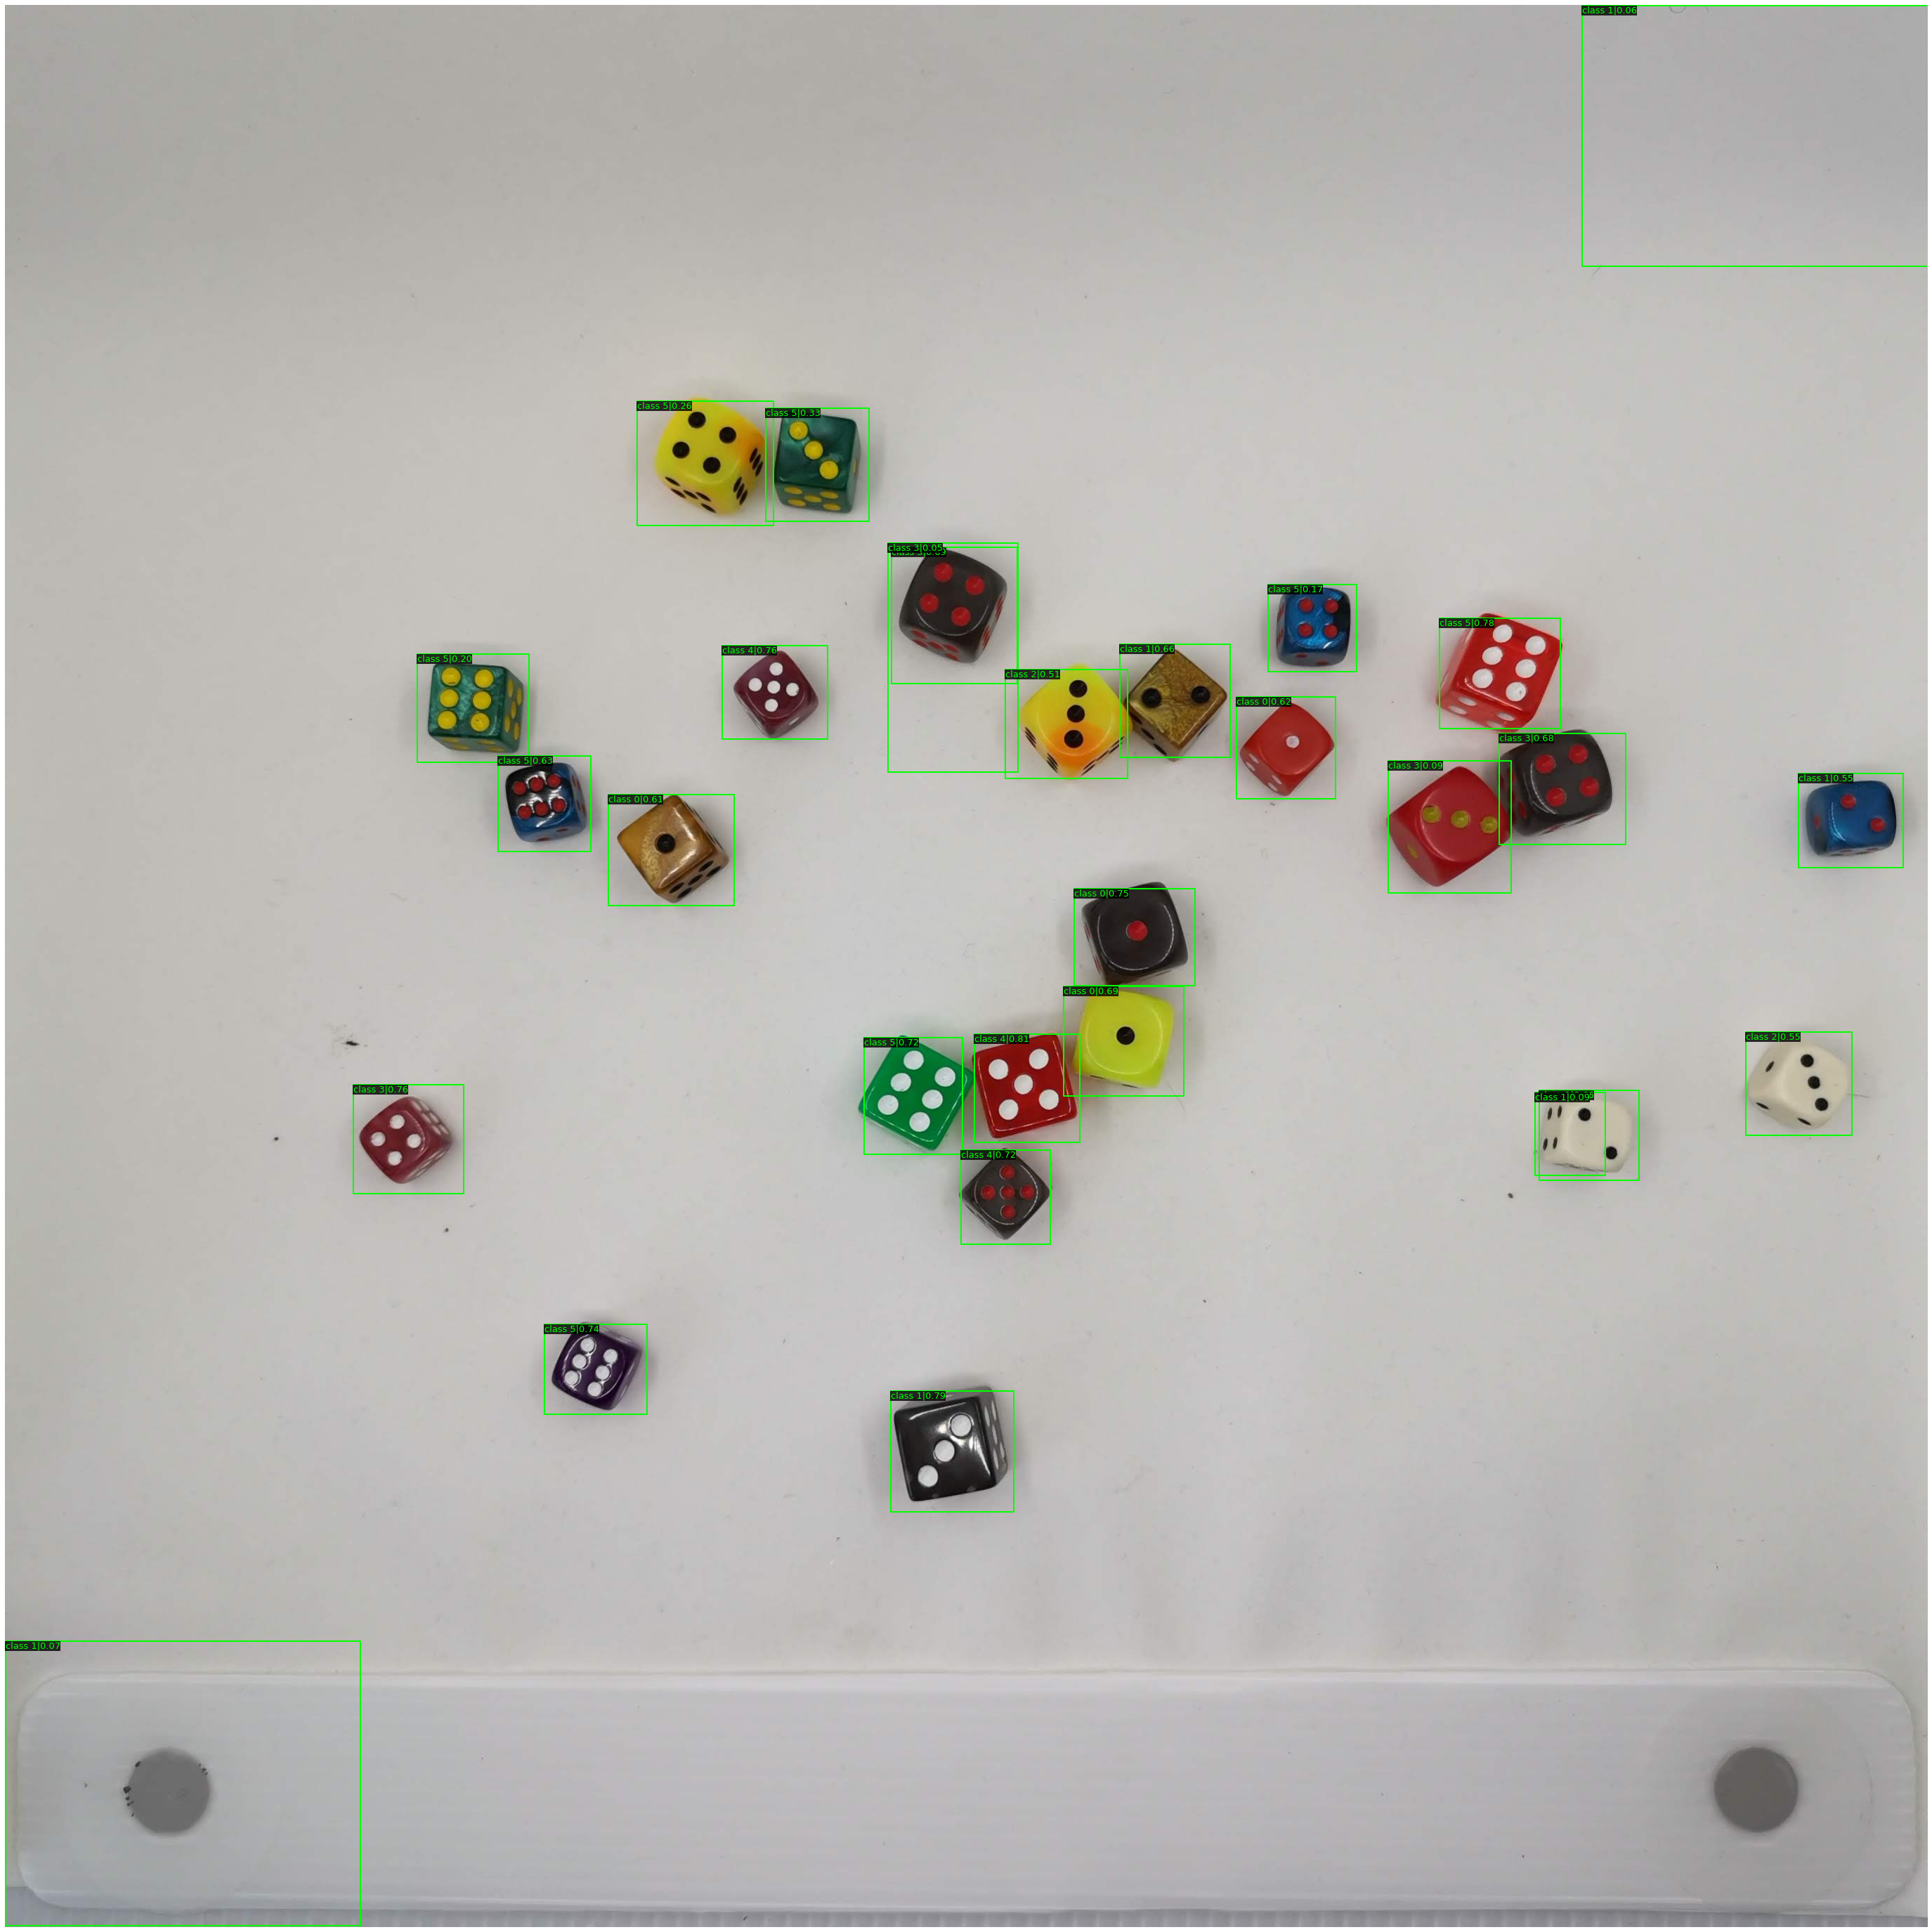

array([[[163, 169, 168],
        [163, 169, 168],
        [163, 169, 168],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[163, 169, 168],
        [163, 169, 168],
        [163, 169, 168],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[163, 169, 168],
        [163, 169, 168],
        [163, 169, 168],
        ...,
        [172, 172, 172],
        [172, 172, 172],
        [172, 172, 172]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [139, 134, 135],
        [138, 133, 134],
        [138, 133, 134]],

       [[ 44, 223,  41],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [139, 134, 135],
        [139, 134, 135],
        [139, 134, 135]],

       [[152, 148, 143],
        [152, 148, 143],
        [151, 147, 142],
        ...,
        [139, 134, 135],
        [139, 134, 135],
        [139, 134, 135]]

In [5]:
from mmdet.ops.nms import nms

nms_bboxes, indices = nms(bboxes[:, :4], bboxes[:, 4], 0.8)
nms_labels = labels[indices]
print(len(bboxes), len(nms_bboxes), len(nms_labels))

imshow_det_bboxes(im, nms_bboxes, nms_labels)

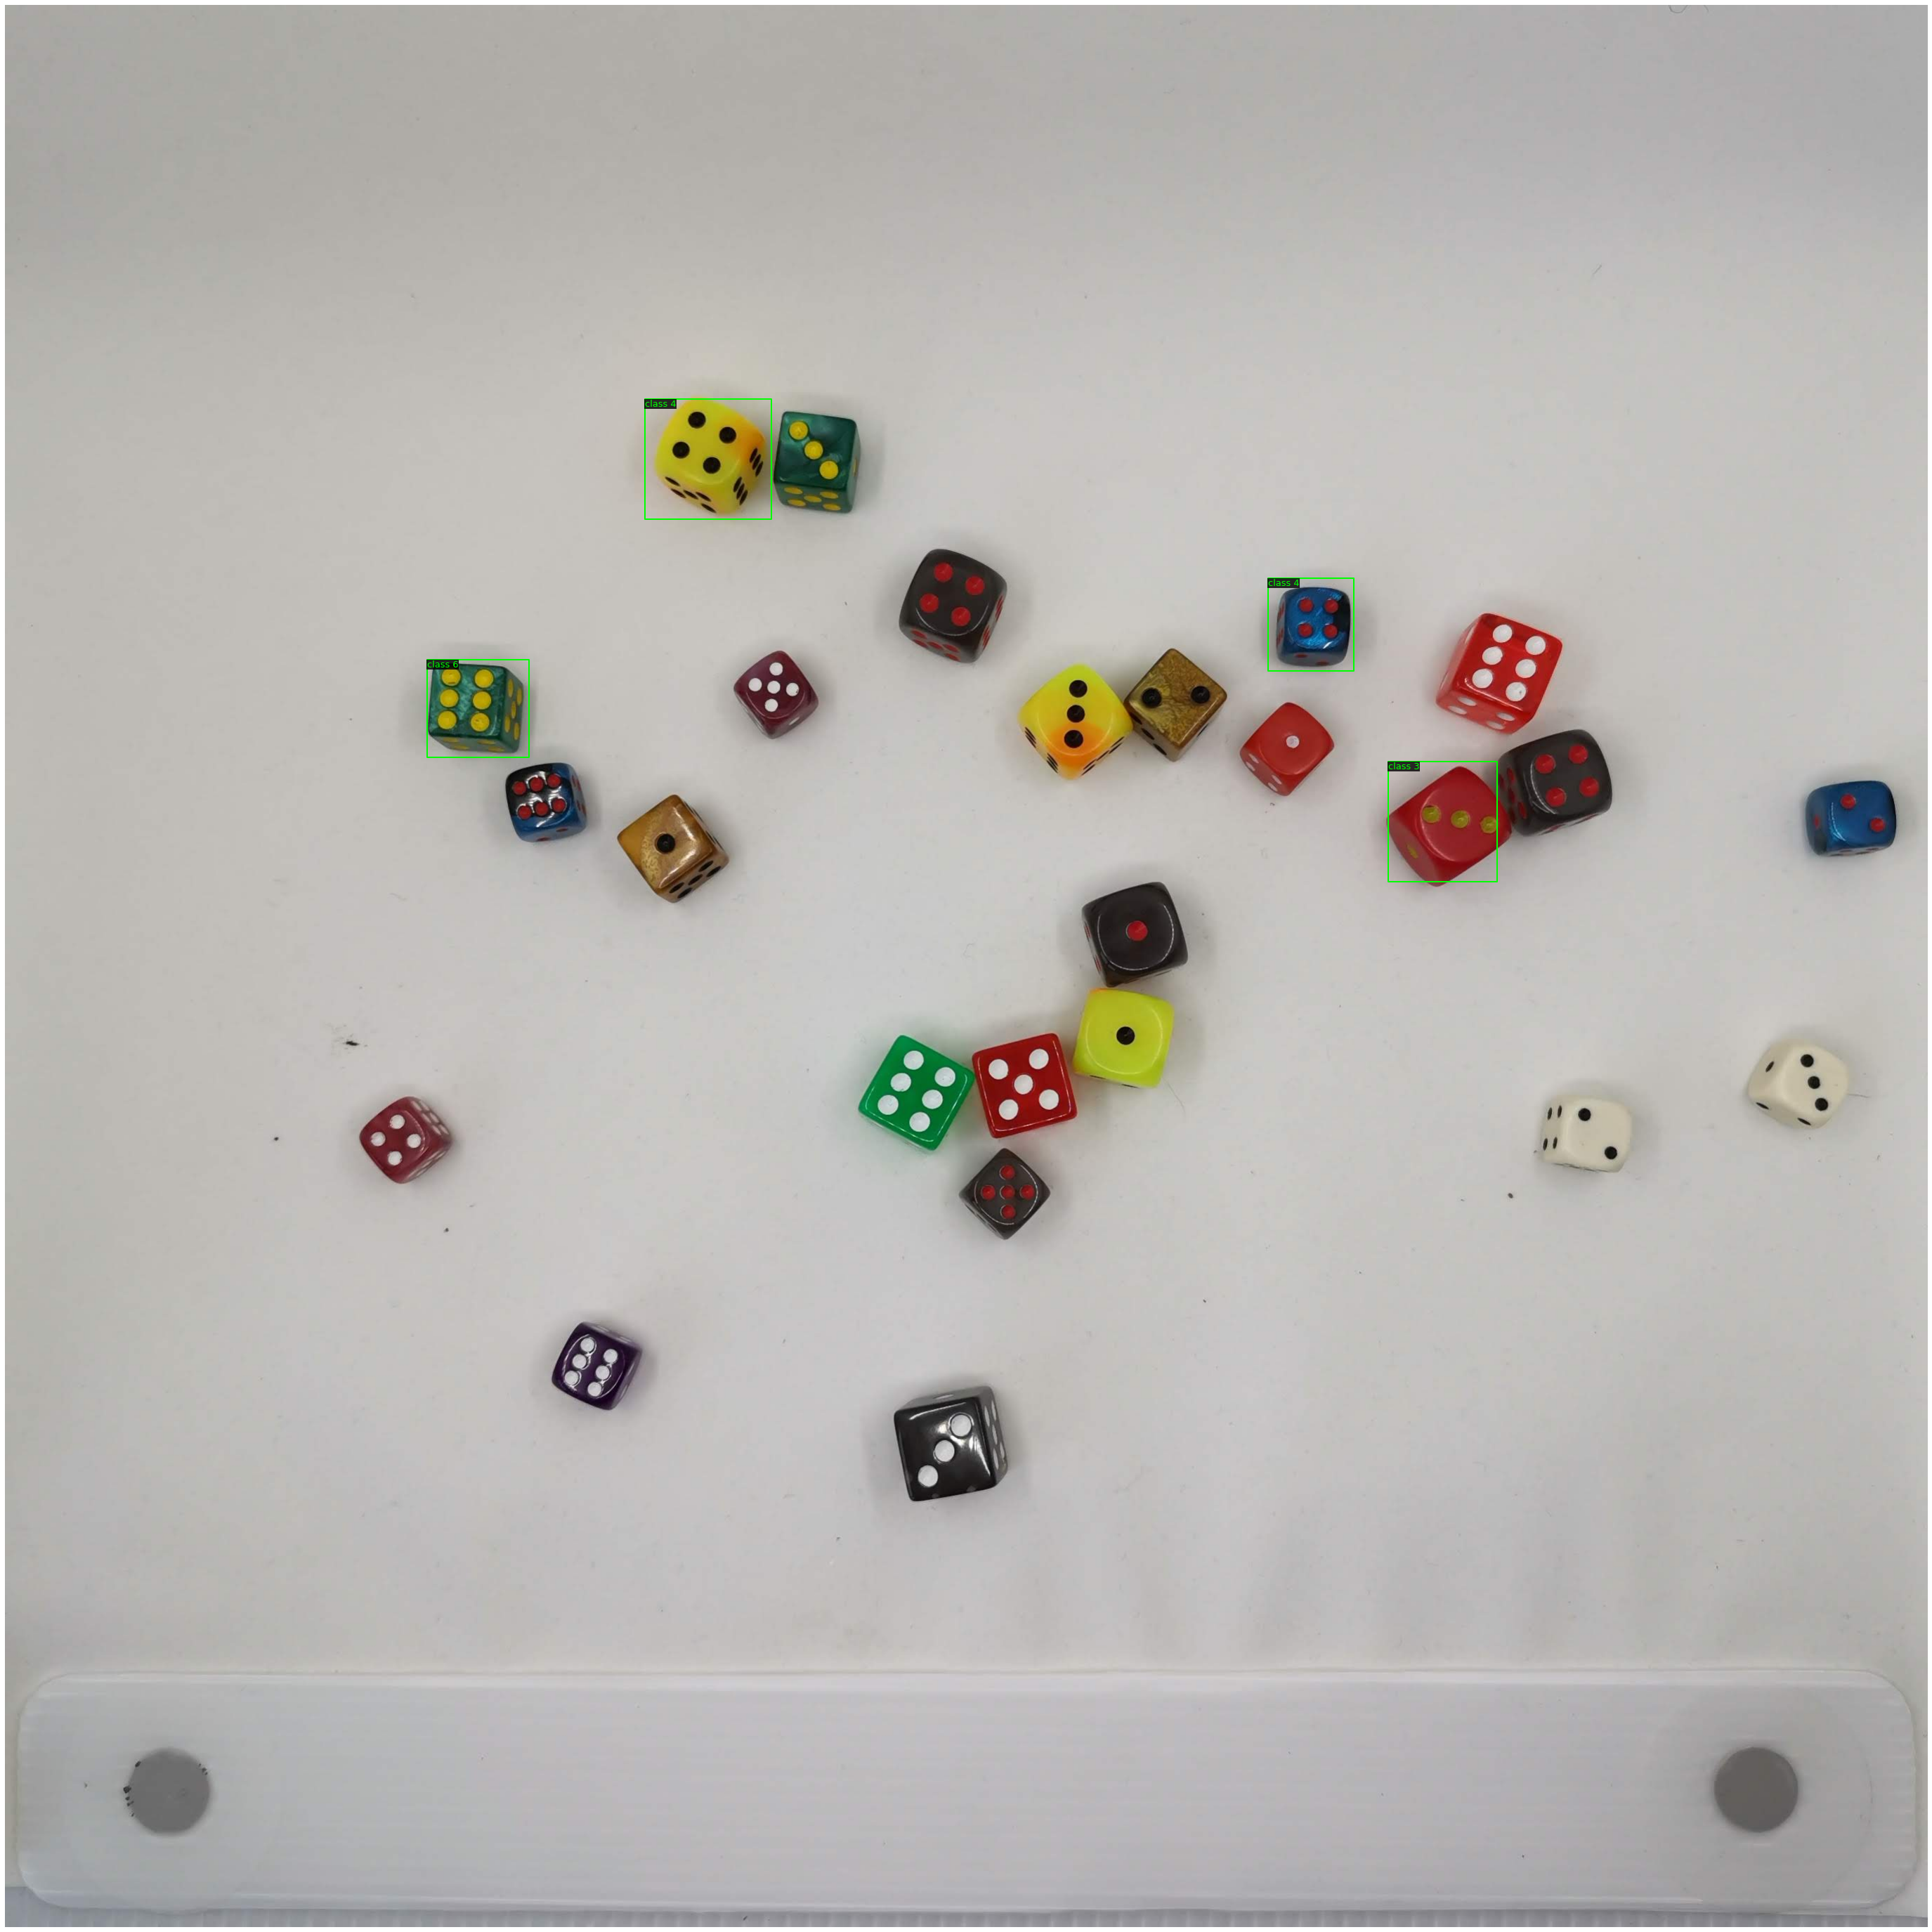

array([[[163, 169, 168],
        [163, 169, 168],
        [163, 169, 168],
        ...,
        [172, 172, 172],
        [172, 172, 172],
        [172, 172, 172]],

       [[163, 169, 168],
        [163, 169, 168],
        [163, 169, 168],
        ...,
        [172, 172, 172],
        [172, 172, 172],
        [172, 172, 172]],

       [[163, 169, 168],
        [163, 169, 168],
        [163, 169, 168],
        ...,
        [172, 172, 172],
        [172, 172, 172],
        [172, 172, 172]],

       ...,

       [[152, 148, 143],
        [152, 148, 143],
        [151, 147, 142],
        ...,
        [139, 134, 135],
        [138, 133, 134],
        [138, 133, 134]],

       [[152, 148, 143],
        [152, 148, 143],
        [151, 147, 142],
        ...,
        [139, 134, 135],
        [139, 134, 135],
        [139, 134, 135]],

       [[152, 148, 143],
        [152, 148, 143],
        [151, 147, 142],
        ...,
        [139, 134, 135],
        [139, 134, 135],
        [139, 134, 135]]

In [6]:
bboxes = []
labels = []

for ann in anno["annotations"]:
    if ann["image_id"] == img_id and ann["noise"] == 3:
        x1, y1, w, h = ann["bbox"]
        bboxes += [(x1, y1, x1 + w, y1 + h)]
        labels += [ann["category_id"]]

bboxes = np.asarray(bboxes)
labels = np.asarray(labels)

imshow_det_bboxes(im, bboxes, labels)

In [9]:
from copy import deepcopy

anno_fix, n_fix_miss = correct_missing_labels(
    deepcopy(anno),
    train_preds,
    noise_rate=noise_rate,
    iou_thresholds=0.9,
    min_size=10,
)

correct id=44
correct id=126
correct id=113
correct id=119
correct id=120


In [ ]:
cands, dts = get_missing_label_cands(anno, train_preds, 1.0, 0.5, 10)

In [ ]:
bboxes = []
labels = []

for ann in anno["annotations"]:
    if ann["image_id"] == img_id and ann["noise"] == 3:
        x1, y1, w, h = ann["bbox"]
        bboxes += [(x1, y1, x1 + w, y1 + h)]
        labels += [ann["category_id"]]

bboxes = np.asarray(bboxes)
labels = np.asarray(labels)

imshow_det_bboxes(im, bboxes, labels)